# Risk Analysis

# Goal:
One primary source of risk for DealShield is that more guaranteed vehicles will be returned than anticipated. 

In this case study, DealShield is experiencing a higher than expected return rate, and losses are rising quickly. You are asked to create a "risky dealer score" that will indicate which dealers are more likely to return an excessive number of vehicles based upon their known dealer characteristics, past purchasing behavior, and purchased vehicle characteristics. A return rate above 10% is considered excessive. 

The goal is to be able to score each dealer in the dataset (even those who have no DealShield purchase history) so that a buyer whose "risky dealer score" is too high can be prohibited from purchasing DealShield guarantees in the future.

1. Can you develop the requested "risky dealer score" and validate its performance? 
2. Can you identify and explain those dealer characteristics and behaviors that indicate the dealer is of greater risk?

# Data


The Risky Dealer Case Study Transactions file contains records of wholesale vehicle sales. Each record gives specific details of the sales transaction. 

Note that only some of these transactions have a DealShield guarantee applied to them, and of those, some result in a returned vehicle and others do not. 

Descriptions of each field contained in the file are given below. Also note that the data is not intended to be perfect. That is, as usual, data that you have to use in your analysis is often "dirty" and may contain occassional erroneous or missing values. You must treat these accordingly and provide reasoning behind any action you may take to handle such data. 

In [1]:
import pandas as pd
import numpy as np

#%run shared_functions.py

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


# Data Structure

In [2]:
df = pd.read_csv('data/Risky Dealer Case Study/Risky Dealer Case Study Transactions.csv')
df.head()

,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,Salvage,OVE,Simulcast,InLane,PSIEligible,SaleDate,Autocheck_score,ConditionReport,DSEligible,Returned
0,351757,441081,37055,1FAHP3M27CL374352,CAAI,FORD,13000,2012,13050,COMPACT CAR,...,0,0,0,0,1,13-07-25,1.000000,NaN,1,0.0
1,351757,442235,248,1G1JE6SB7D4103706,DETA,CHEVROLET,13900,2013,13600,COMPACT CAR,...,0,0,0,0,1,13-10-24,NaN,NaN,1,NaN
2,351757,436280,39627,1G1PG5SC4C7102274,CAAI,CHEVROLET,13800,2012,14050,MIDSIZE CAR,...,0,0,0,1,1,13-04-18,-2.666667,41,1,NaN
3,351757,436280,50773,1G1PG5SC5C7113820,CAAI,CHEVROLET,12900,2012,13150,MIDSIZE CAR,...,0,0,0,1,1,13-04-18,1.000000,31,1,NaN
4,351757,434202,54133,1GNKVGED4BJ301146,SVAA,CHEVROLET,17800,2011,18050,SUV,...,0,0,0,1,1,13-02-26,-1.400000,34,1,NaN


In [3]:
for d in df.columns:
    print(d)

BuyerID
SellerID
Mileage
VIN
SellingLocation
CarMake
SalePrice
CarYear
MMR
JDPowersCat
LIGHTG
LIGHTY
LIGHTR
PSI
Arbitrated
Salvage
OVE
Simulcast
InLane
PSIEligible
SaleDate
Autocheck_score
ConditionReport
DSEligible
Returned


# Preprocessing
1. convert categorical attributes: 'SellingLocation', 'CarMake','JDPowersCat','CarYear','LIGHTG', 'LIGHTY', \
       'LIGHTR', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane',
       'PSIEligible'
2. selected features: 'Mileage', 'SalePrice', 'MMR', 'PSI', 'SellingLocation', 'CarMake','JDPowersCat','CarYear','LIGHTG', 'LIGHTY', \
       'LIGHTR', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane',
       'PSIEligible'
3. output feature: 'Returned'
4. ignored features: 
    4.1 Missing values: Autocheck_score	ConditionReport
    4.2 Uncertain features: DSEligible
    4.3 unrelated features: 'BuyerID', 'SellerID', 'CarYear', 'SaleDate'

In [4]:
from sklearn import preprocessing
def convert_categorical(data_df):
    label_encoder = preprocessing.LabelEncoder()
    for c in ['SellingLocation', 'CarMake','JDPowersCat','CarYear','LIGHTG', 'LIGHTY', \
           'LIGHTR', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane',
           'PSIEligible']:
        data_df[c+'_label']= label_encoder.fit_transform(data_df[c])
    #oh_encoder = preprocessing.OneHotEncoder()
    oh_encoder = preprocessing.OneHotEncoder(categories='auto') 
    np_labels = oh_encoder.fit_transform(data_df[['SellingLocation_label', 'CarMake_label','JDPowersCat_label',\
                            'CarYear_label','LIGHTG_label', 'LIGHTY_label', 'LIGHTR_label', 'Arbitrated_label',  \
                           'Salvage_label', 'OVE_label', 'Simulcast_label', 'InLane_label', \
                           'PSIEligible_label']]).toarray()
    data_df = pd.concat([data_df, pd.DataFrame(np_labels)],axis=1)
    return data_df


In [5]:
# df_clean = pd.concat([df_clean, pd.DataFrame(np_labels)])
# df_clean.shape

In [6]:
df_clean = convert_categorical(df)
df_clean.shape

(278337, 371)

In [7]:
df_clean.columns

Index([        'BuyerID',        'SellerID',         'Mileage',
                   'VIN', 'SellingLocation',         'CarMake',
             'SalePrice',         'CarYear',             'MMR',
           'JDPowersCat',
       ...
                     323,               324,               325,
                     326,               327,               328,
                     329,               330,               331,
                     332],
      dtype='object', length=371)

In [8]:
output_feature="Returned"

input_features=['Mileage', 'SalePrice', 'MMR', 'PSI'] #, 'Autocheck_score'] #'ConditionReport',]

names = {}
for i in range(332):
    input_features.append(str(i))
    names[i] = str(i)
df_clean = df_clean.rename(columns=names)

In [9]:
df_clean.shape

(278337, 371)

Note that green, yellow, and red lights should not appear in combination. If this occurs it is a data error. In this case default to the highest warning when multiple lights exist.

In [10]:
df_clean['check-GYR'] = df_clean[['LIGHTG','LIGHTY','LIGHTR']].apply(lambda s:False if s[0]==s[1]==1 or s[0]==s[2]==1 or s[1]==s[2]==1 else True, axis=1)
df_clean = df_clean[df_clean['check-GYR']].drop('check-GYR',axis=1)
df_clean.shape

(262678, 371)

Statistics and correlation of the data show that all the attribures are independent.


In [11]:
df_selected = df_clean.dropna(subset=['Returned','JDPowersCat'])[input_features+[output_feature]]
df_selected = df_selected.fillna(value=0)
df_selected.shape

(18894, 337)

In [12]:
df_selected[input_features].dropna().describe()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,322,323,324,325,326,327,328,329,330,331
count,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.0,18894.0,18894.000000,...,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000
mean,84849.706203,11374.059013,10865.581666,0.200699,0.001217,0.000370,0.000423,0.0,0.0,0.004816,...,0.212501,0.963639,0.036361,0.988515,0.011485,0.950249,0.049751,0.775749,0.224251,0.344977
std,46164.647381,7587.682777,7574.858363,0.400534,0.034870,0.019245,0.020573,0.0,0.0,0.069234,...,0.409088,0.187191,0.187191,0.106554,0.106554,0.217436,0.217436,0.417099,0.417099,0.475373
min,1.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45976.000000,6100.000000,5425.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
50%,83286.000000,10000.000000,9625.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000
75%,114668.750000,15000.000000,14700.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,363570.000000,163000.000000,81000.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [13]:
df_selected[input_features].corr()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,322,323,324,325,326,327,328,329,330,331
Mileage,1.000000,-0.610216,-0.583052,-0.091615,-0.015710,-0.001760,-0.012881,NaN,NaN,0.047110,...,0.136032,-0.121314,0.121314,0.067782,-0.067782,0.058650,-0.058650,0.026392,-0.026392,0.645216
SalePrice,-0.610216,1.000000,0.894166,0.054141,0.009422,-0.014759,0.006987,NaN,NaN,-0.028105,...,-0.074338,0.078472,-0.078472,-0.118386,0.118386,-0.040469,0.040469,-0.002810,0.002810,-0.382298
MMR,-0.583052,0.894166,1.000000,0.040743,0.001311,-0.012974,0.006937,NaN,NaN,-0.026147,...,-0.065054,0.071749,-0.071749,-0.071431,0.071431,-0.042519,0.042519,0.002145,-0.002145,-0.363597
PSI,-0.091615,0.054141,0.040743,1.000000,0.020404,0.017820,0.008957,NaN,NaN,0.070119,...,-0.092324,0.070510,-0.070510,-0.072487,0.072487,-0.055514,0.055514,-0.065469,0.065469,-0.256625
0,-0.015710,0.009422,0.001311,0.020404,1.000000,-0.000672,-0.000719,NaN,NaN,-0.002429,...,-0.003293,0.006781,-0.006781,0.003763,-0.003763,-0.068803,0.068803,0.011492,-0.011492,-0.012563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
327,0.058650,-0.040469,-0.042519,-0.055514,-0.068803,-0.020893,-0.030787,NaN,NaN,-0.026274,...,0.027224,0.063487,-0.063487,-0.024664,0.024664,1.000000,-1.000000,-0.123024,0.123024,0.040596
328,-0.058650,0.040469,0.042519,0.055514,0.068803,0.020893,0.030787,NaN,NaN,0.026274,...,-0.027224,-0.063487,0.063487,0.024664,-0.024664,-1.000000,1.000000,0.123024,-0.123024,-0.040596
329,0.026392,-0.002810,0.002145,-0.065469,0.011492,0.010351,0.011066,NaN,NaN,-0.010252,...,0.064015,0.080631,-0.080631,-0.057954,0.057954,-0.123024,0.123024,1.000000,-1.000000,0.012458
330,-0.026392,0.002810,-0.002145,0.065469,-0.011492,-0.010351,-0.011066,NaN,NaN,0.010252,...,-0.064015,-0.080631,0.080631,0.057954,-0.057954,0.123024,-0.123024,-1.000000,1.000000,-0.012458


In [14]:
df_selected.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,323,324,325,326,327,328,329,330,331,Returned
0,37055,13000,13050,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
11,38671,11000,12650,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0
17,25010,14700,14750,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
27,40589,11700,12400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
28,36386,13600,14400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [15]:

df_positive = df_selected[df_selected['Returned']==0].copy()
df_negative = df_selected[df_selected['Returned']==1].copy()

In [16]:
df_positive.shape, df_negative.shape

((14917, 337), (3977, 337))

In [17]:
df_positive.columns

Index(['Mileage', 'SalePrice', 'MMR', 'PSI', '0', '1', '2', '3', '4', '5',
       ...
       '323', '324', '325', '326', '327', '328', '329', '330', '331',
       'Returned'],
      dtype='object', length=337)

# Sample Selection
Select 2000 records with Returned=0 as positive samples
Select 2000 records with Returned=1 as negative samples

In [18]:
train_df = pd.concat([df_positive[:2000],df_negative[:2000]])
test_df = pd.concat([df_positive[2000:4000],df_negative[2000:]])

In [19]:
train_df[input_features].dropna().shape, test_df[input_features].dropna().shape

((4000, 336), (3977, 336))

In [20]:
train_df.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,323,324,325,326,327,328,329,330,331,Returned
0,37055,13000,13050,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
17,25010,14700,14750,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
27,40589,11700,12400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
28,36386,13600,14400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
29,70294,14200,14550,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [21]:
test_df.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,323,324,325,326,327,328,329,330,331,Returned
43182,37791,25800,25800,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
43186,68249,10300,9850,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
43188,56620,10800,9675,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
43193,92443,4700,4900,0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
43206,68623,9400,8025,1,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Model Training
1. selected machine learning models: 'Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Deep Learning'
2. The best model: 'XGBoost'

In [22]:

def scaleData(train,test,features):
    scaler = sklearn.preprocessing.StandardScaler()
    scaler.fit(train[features])
    train[features]=scaler.transform(train[features])
    test[features]=scaler.transform(test[features])
    
    return (train,test)


In [23]:
fitted_models_and_predictions_dictionary={}

In [24]:
def performance_assessment(predictions_df, output_feature='Returned', 
                           prediction_feature='predictions'):
    
    AUC_ROC = metrics.roc_auc_score(predictions_df[output_feature], predictions_df[prediction_feature])
    AP = metrics.average_precision_score(predictions_df[output_feature], predictions_df[prediction_feature])
    
    performances = pd.DataFrame([[AUC_ROC, AP]], 
                           columns=['AUC ROC','Average precision'])

    performances = performances.round(3)
    
    return performances



def performance_assessment_model_collection(fitted_models_and_predictions_dictionary, 
                                            transactions_df, 
                                            type_set='test'):

    performances=[]
    
    for classifier_name, model_and_predictions in fitted_models_and_predictions_dictionary.items():
    
        predictions_df=transactions_df
            
        predictions_df['predictions']=model_and_predictions['predictions_'+type_set]
        
        performances_model=performance_assessment(predictions_df, output_feature=output_feature, \
                                                   prediction_feature='predictions')
        performances_model.index=[classifier_name]
        
        #performances=performances.append(performances_model)
        performances.append(performances_model)
    return pd.concat(performances) 

In [25]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical as one_hot
import yolov4

In [26]:
#import nvidia_smi
import GPUtil
import psutil

In [27]:
cpu_usage = psutil.cpu_percent()
mem_usage = psutil.virtual_memory().percent
print(f'cpu_usage: {cpu_usage}, memory_usage: {mem_usage}')

GPUtil.showUtilization()

cpu_usage: 9.7, memory_usage: 63.7
| ID | GPU | MEM |
------------------
|  0 |  1% |  7% |


In [28]:
devices = tf.config.experimental.list_physical_devices('GPU')
for d in devices:
    tf.config.set_logical_device_configuration(
    d,
    [tf.config.LogicalDeviceConfiguration(100),
     tf.config.LogicalDeviceConfiguration(100)])
devices_names = [d.name.split("e:")[1] for d in devices]
mirrored_strategy = tf.distribute.MirroredStrategy(devices=devices_names)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [29]:

N_CLASSES = 2

hidden_size = 293

class DeepLearningModel(tf.keras.Model):
    def __init__(self):
        super(DeepLearningModel, self).__init__()
        self.hidden_size = hidden_size
        self.hidden_layer1 = keras.layers.Dense(
            self.hidden_size,
            activation='relu',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)
        )
        self.hidden_size = self.hidden_size//2
        self.hidden_layer2 = keras.layers.Dense(
            self.hidden_size,
            activation='relu',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)
        )
        
        self.hidden_size = self.hidden_size//2
        self.hidden_layer3 = keras.layers.Dense(
            self.hidden_size,
            activation='relu',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)
        )
        self.prediction_layer = keras.layers.Dense(
            2,
            activation='softmax',
            kernel_initializer=keras.initializers.TruncatedNormal(mean=0., stddev=1.)
        )
        
        
        self.model = keras.Sequential()
        self.model.add(self.hidden_layer1)
        self.model.add(self.hidden_layer2)
        self.model.add(self.hidden_layer3)
        
    def call(self, inputs):
        
        latent = self.model(inputs)
        return self.prediction_layer(latent)

with mirrored_strategy.scope():
    model = DeepLearningModel()
    model.compile(loss='categorical_crossentropy',
                  optimizer=keras.optimizers.SGD(lr=0.001),
                  metrics=['accuracy'])
    earlystopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,
                                                  verbose=1, min_delta=.01)

history = model.fit(train_df[input_features], one_hot(train_df[output_feature]),
                    epochs=100,
                    batch_size=30,
                    validation_data=(test_df[input_features],one_hot(test_df[output_feature])),
                   callbacks = [earlystopping])

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
Epoch 1/100


C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizer_v2\gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
134/134 [==============================] - 5s 15ms/step - loss: nan - accuracy: 0.4980 - val_loss: nan - val_accuracy: 0.5029
Epoch 2/100
134/134 [=============

In [30]:

history = model.fit(train_df[input_features], one_hot(train_df[output_feature]),
                    epochs=100,
                    batch_size=30,
                    validation_data=(test_df[input_features],one_hot(test_df[output_feature])),
                   callbacks = [earlystopping])


predictions_test=model.predict(test_df[input_features])
predictions_test = [np.argmax(i) for i in predictions_test]

predictions_train=model.predict(train_df[input_features])
predictions_train = [np.argmax(i) for i in predictions_test]


model_and_predictions_dictionary = {'classifier': 'Deep Learning',
                                    'predictions_test': predictions_test,
                                    'predictions_train': predictions_train
                                   }

fitted_models_and_predictions_dictionary['Deep Learning'] = model_and_predictions_dictionary

Epoch 1/100
134/134 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 2/100
134/134 [==============================] - 1s 5ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 3/100
134/134 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 4/100
134/134 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 5/100
134/134 [==============================] - 1s 6ms/step - loss: nan - accuracy: 0.5000 - val_loss: nan - val_accuracy: 0.5029
Epoch 5: early stopping


In [31]:
import sklearn
from sklearn import *

import math
import sys
import time
#import graphviz
import xgboost

# For imbalanced learning
import imblearn

import warnings
warnings.filterwarnings('ignore')


IR=1.0/4.0
IR=1.0/1.0

class_weight={0:IR,1:1.0}

classifiers_dictionary={'Logistic regression':sklearn.linear_model.LogisticRegression(random_state=0), 
                        'Decision tree with depth of two': sklearn.tree.DecisionTreeClassifier(max_depth=5,class_weight=class_weight,random_state=0),#sklearn.tree.DecisionTreeClassifier(max_depth=2,random_state=0), 
                        'Decision tree - unlimited depth':sklearn.tree.DecisionTreeClassifier(class_weight=class_weight,random_state=0), #sklearn.tree.DecisionTreeClassifier(random_state=0), 
                        'Random forest':sklearn.ensemble.RandomForestClassifier(class_weight=class_weight,random_state=0,n_jobs=-1),
                        'XGBoost':xgboost.XGBClassifier(random_state=0,n_jobs=-1),
                       }


for classifier_name in classifiers_dictionary:
    
    (train_df, test_df)=scaleData(train_df,test_df,input_features)
    
    classifier = classifiers_dictionary[classifier_name]
    classifier.fit(train_df[input_features], train_df[output_feature])

    predictions_test=classifier.predict_proba(test_df[input_features])[:,1]
    
    predictions_train=classifier.predict_proba(train_df[input_features])[:,1]

    model_and_predictions_dictionary = {'classifier': classifier,
                                        'predictions_test': predictions_test,
                                        'predictions_train': predictions_train
                                       }
    
    fitted_models_and_predictions_dictionary[classifier_name] = model_and_predictions_dictionary


In [32]:
# performances on test set with all features
df_performances=performance_assessment_model_collection(fitted_models_and_predictions_dictionary, test_df, 
                                                        type_set='test')
df_performances

,AUC ROC,Average precision
Deep Learning,0.500,0.497
Logistic regression,0.945,0.916
Decision tree with depth of two,0.968,0.960
Decision tree - unlimited depth,0.762,0.680
Random forest,0.965,0.961
XGBoost,0.961,0.963


# Model Performance Evaluation
By comparing the distribution of original data set and the misclassified data set, the mean, mean+std and mean-std become smaller in misclassified data set. In other words, the reason for misclassifying records is because the sample set is biased. More samples with the values less than averages should be added.

In [33]:
train_df.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,323,324,325,326,327,328,329,330,331,Returned
0,-0.867454,0.081630,0.162967,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0
17,-1.140317,0.304894,0.383413,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,-2.068102,2.068102,-0.609321,0.0
27,-0.787397,-0.089101,0.078679,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0
28,-0.882610,0.160429,0.338027,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,-2.068102,2.068102,-0.609321,0.0
29,-0.114471,0.239228,0.357478,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,0.164188,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0


In [34]:
test_df.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,predictions
43182,-0.850781,1.762677,1.816311,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0,0.001537
43186,-0.160798,-0.272966,-0.251990,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0,0.037771
43188,-0.424236,-0.207300,-0.274683,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,-0.609321,0.0,0.029441
43193,0.387284,-1.008424,-0.893876,-0.483142,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,0.483535,-0.483535,1.641172,0.0,0.028704
43206,-0.152325,-0.391164,-0.488645,2.069786,-0.031639,0.0,-0.031639,0.0,0.0,-0.038759,...,-0.164188,0.076048,-0.076048,0.217703,-0.217703,-2.068102,2.068102,-0.609321,0.0,0.006373


In [35]:
classifier = classifiers_dictionary['XGBoost']#['Random forest']#
df_selected = df_selected.fillna(value=0)
df_selected['prediction'] = classifier.predict_proba(df_selected[input_features])[:,1]

df_selected.head()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,prediction
0,37055,13000,13050,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.050450
11,38671,11000,12650,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.086778
17,25010,14700,14750,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.222267
27,40589,11700,12400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.222267
28,36386,13600,14400,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.222267


In [36]:
df_clean_eval = df_selected.copy()
df_clean_eval['check'] = df_clean_eval[['Returned','prediction']].apply(lambda s: True if (s[0]<0.5 and s[1]<0.5) or (s[0]>=0.5 and s[1]>=0.5) else False,axis=1 )
df_clean_eval[df_clean_eval['check']==False].shape

(4188, 339)

In [37]:
df_clean_false = df_clean_eval[df_clean_eval['check']==False].copy() #pd.read_csv('data/test_false.csv')
df_clean_false.describe()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,prediction
count,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.0,4188.000000,4188.0,4188.0,4188.000000,...,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000
mean,96159.174069,10377.519102,9370.218481,0.089303,0.001194,0.0,0.000478,0.0,0.0,0.002627,...,0.059456,0.993075,0.006925,0.963945,0.036055,0.826886,0.173114,0.494986,0.931948,0.170848
std,46313.252270,8095.036596,7964.625447,0.285214,0.034536,0.0,0.021850,0.0,0.0,0.051189,...,0.236504,0.082935,0.082935,0.186450,0.186450,0.378391,0.378391,0.500035,0.251864,0.141323
min,1.000000,350.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001430
25%,63447.000000,4600.000000,3525.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.075158
50%,93455.000000,8400.000000,7600.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.184191
75%,126461.500000,13800.000000,13050.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.218270
max,312010.000000,80750.000000,81000.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.730516


In [38]:
df_clean_eval.describe()

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,prediction
count,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.0,18894.0,18894.000000,...,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000
mean,84849.706203,11374.059013,10865.581666,0.200699,0.001217,0.000370,0.000423,0.0,0.0,0.004816,...,0.036361,0.988515,0.011485,0.950249,0.049751,0.775749,0.224251,0.344977,0.210490,0.147253
std,46164.647381,7587.682777,7574.858363,0.400534,0.034870,0.019245,0.020573,0.0,0.0,0.069234,...,0.187191,0.106554,0.106554,0.217436,0.217436,0.417099,0.417099,0.475373,0.407668,0.112309
min,1.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001430
25%,45976.000000,6100.000000,5425.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.048086
50%,83286.000000,10000.000000,9625.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.145369
75%,114668.750000,15000.000000,14700.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.218270
max,363570.000000,163000.000000,81000.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.730516


In [39]:
df_stats = df_clean_eval.describe()
df_stats

,Mileage,SalePrice,MMR,PSI,0,1,2,3,4,5,...,324,325,326,327,328,329,330,331,Returned,prediction
count,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.0,18894.0,18894.000000,...,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000,18894.000000
mean,84849.706203,11374.059013,10865.581666,0.200699,0.001217,0.000370,0.000423,0.0,0.0,0.004816,...,0.036361,0.988515,0.011485,0.950249,0.049751,0.775749,0.224251,0.344977,0.210490,0.147253
std,46164.647381,7587.682777,7574.858363,0.400534,0.034870,0.019245,0.020573,0.0,0.0,0.069234,...,0.187191,0.106554,0.106554,0.217436,0.217436,0.417099,0.417099,0.475373,0.407668,0.112309
min,1.000000,250.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001430
25%,45976.000000,6100.000000,5425.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.048086
50%,83286.000000,10000.000000,9625.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.145369
75%,114668.750000,15000.000000,14700.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.218270
max,363570.000000,163000.000000,81000.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.730516


In [40]:
df_stats_false = df_clean_false.describe()
for c in df_stats_false.columns:
    df_stats_false = df_stats_false.rename(columns={c:c+'_false'})
df_stats_false

,Mileage_false,SalePrice_false,MMR_false,PSI_false,0_false,1_false,2_false,3_false,4_false,5_false,...,324_false,325_false,326_false,327_false,328_false,329_false,330_false,331_false,Returned_false,prediction_false
count,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.0,4188.000000,4188.0,4188.0,4188.000000,...,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000,4188.000000
mean,96159.174069,10377.519102,9370.218481,0.089303,0.001194,0.0,0.000478,0.0,0.0,0.002627,...,0.059456,0.993075,0.006925,0.963945,0.036055,0.826886,0.173114,0.494986,0.931948,0.170848
std,46313.252270,8095.036596,7964.625447,0.285214,0.034536,0.0,0.021850,0.0,0.0,0.051189,...,0.236504,0.082935,0.082935,0.186450,0.186450,0.378391,0.378391,0.500035,0.251864,0.141323
min,1.000000,350.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001430
25%,63447.000000,4600.000000,3525.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.075158
50%,93455.000000,8400.000000,7600.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,0.184191
75%,126461.500000,13800.000000,13050.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,...,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.218270
max,312010.000000,80750.000000,81000.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.730516


In [41]:
df_summary = pd.concat([df_stats_false.T, df_stats.T])
df_summary = df_summary[['mean','std','min','max']]
df_summary['mean-std'] = df_summary[['mean','std']].apply(lambda s: s[0]-s[1],axis=1)
df_summary['mean+std'] = df_summary[['mean','std']].apply(lambda s: s[0]+s[1],axis=1)
df_summary = df_summary[['min','mean-std','mean','mean+std','max']].T
df_summary = df_summary.reset_index()
df_summary = df_summary.rename(columns={'index':'Values'})
df_summary

,Values,Mileage_false,SalePrice_false,MMR_false,PSI_false,0_false,1_false,2_false,3_false,4_false,...,324,325,326,327,328,329,330,331,Returned,prediction
0,min,1.000000,350.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001430
1,mean-std,49845.921799,2282.482506,1405.593035,-0.195912,-0.033342,0.0,-0.021373,0.0,0.0,...,-0.150830,0.881961,-0.095069,0.732812,-0.167685,0.358650,-0.192848,-0.130396,-0.197177,0.034944
2,mean,96159.174069,10377.519102,9370.218481,0.089303,0.001194,0.0,0.000478,0.0,0.0,...,0.036361,0.988515,0.011485,0.950249,0.049751,0.775749,0.224251,0.344977,0.210490,0.147253
3,mean+std,142472.426339,18472.555698,17334.843928,0.374517,0.035730,0.0,0.022328,0.0,0.0,...,0.223552,1.095069,0.118039,1.167685,0.267188,1.192848,0.641350,0.820351,0.618158,0.259562
4,max,312010.000000,80750.000000,81000.000000,1.000000,1.000000,0.0,1.000000,0.0,0.0,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.730516


In [42]:
from ipywidgets import widgets
import matplotlib.pyplot as plt
import numpy as np

import altair as alt

alt.data_transformers.disable_max_rows()



DataTransformerRegistry.enable('default')

In [43]:
size_selector = alt.selection_multi(encodings=['x'])

def summary_plot_alt(data):
    def plotter(column):
        #valid_rows = X[column].notna()
        #plt.plot(X.loc[valid_rows, column], y[valid_rows], '.', color='k')
        #if column.find('_shift')<0:
        scatter = alt.Chart(data, width=500).mark_point().encode(
            x=column,
            y="Values",
            #selected sizes are colored according to the "smoker" column, others are rendered in white
            #color = alt.condition( size_selector , "Time (min)", alt.value("white"))
        )


        scatter_shift = alt.Chart(data, width=500).mark_point().encode(
            x= column+'_false',
            y="Values",
            #selected sizes are colored according to the "smoker" column, others are rendered in white
            #color = alt.condition( size_selector , "Time (min)", alt.value("white"))
        ).add_selection(size_selector)
        
        return scatter & scatter_shift

    return plotter


For DSEligible, PSIEligibal and other attributes, the stats of misclassified data decrease. Records with smaller values are not trained completely.

In [44]:
columns = [c for c in df_summary.drop('Values',axis=1).columns if c.find('_false')<0]
#dropdown_values = {"{0}: {1}".format(k, features_dict[k]):k for k in X.columns}
widgets.interact(summary_plot_alt(df_summary), column=columns);

interactive(children=(Dropdown(description='column', options=('Mileage', 'SalePrice', 'MMR', 'PSI', '0', '1', …

# Dealer Score Computation
1. The attribute DSEligible can be adjusted by using Risky Dealer Score
2. Risky Dealer Score can be defined with the attribute Returned. 
    2.1 Predict the values of the attribute Returned with the trained model.
    2.2 Using predicted values of the attribute Returned to define new DSEligible values: When the attribute Returned is Yes=1, DSEligible=0, otherwise, DSEligible=1.
    2.3 Compute Risky Dealer Score: based on new DSEligible values, for each dealer, compute the ratio of count(new DSEligible == DSEligible)/count(records for the dealer) 
    2.4 if the ratio for a dealer is less than 0.1, the dealer is considered as a risky dealer.
3. Conclusion: In 16000 dealers, 845 dealers are considered as risky dealers.

In [45]:
df_classified = df_clean.dropna(subset=['JDPowersCat'])
classifier = classifiers_dictionary['XGBoost']#['Random forest']#
df_classified = df_classified.fillna(value=0)
df_classified['prediction'] = classifier.predict_proba(df_classified[input_features])[:,1]

df_classified['check'] = df_classified[['DSEligible','prediction']].apply(lambda s: True if (s[0]>0.5 and s[1]<=0.5) or (s[0]<=0.5 and s[1]>0.5) else False, axis=1)
df_classified.head()

,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,325,326,327,328,329,330,331,332,prediction,check
0,351757,441081,37055,1FAHP3M27CL374352,CAAI,FORD,13000,2012,13050,COMPACT CAR,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.050450,True
1,351757,442235,248,1G1JE6SB7D4103706,DETA,CHEVROLET,13900,2013,13600,COMPACT CAR,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.218270,True
2,351757,436280,39627,1G1PG5SC4C7102274,CAAI,CHEVROLET,13800,2012,14050,MIDSIZE CAR,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.145407,True
3,351757,436280,50773,1G1PG5SC5C7113820,CAAI,CHEVROLET,12900,2012,13150,MIDSIZE CAR,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.145407,True
4,351757,434202,54133,1GNKVGED4BJ301146,SVAA,CHEVROLET,17800,2011,18050,SUV,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.007325,True


In [46]:
score_list = []
df_classified = df_classified[list(df.columns)+['prediction','check']]
for k, v in df_classified.groupby(['SellerID']):
    sellerID = v['SellerID'].values[0]
    pos = v[v['check']==True].shape[0]
    neg = v[v['check']==False].shape[0]
    if pos+neg>0:
        score = pos/(pos+neg)
    else: 
        score = 0
    score_list.append((sellerID,score))


In [47]:
len(score_list),df_classified['SellerID'].nunique()

(16000, 16000)

In [48]:
df_seller_score = pd.DataFrame(score_list)
df_seller_score.head()

,0,1
0,0,1.0
1,573,1.0
2,612,1.0
3,615,1.0
4,1023,1.0


In [49]:
df_seller_score[df_seller_score[1]>0.1].shape

(15146, 2)

In [50]:
df_seller_score[df_seller_score[1]<=0.1].shape

(854, 2)

In [51]:
df_risky = pd.merge(df_classified, df_seller_score, left_on='SellerID',right_on=0, how='left')
df_risky = df_risky.rename(columns={0:'SellerID0',1:'RiskyDealerScore'})
df_risky = df_risky.drop(['SellerID0','check'],axis=1)
df_risky.head()

,BuyerID,SellerID,Mileage,VIN,SellingLocation,CarMake,SalePrice,CarYear,MMR,JDPowersCat,...,LIGHTY_label,LIGHTR_label,Arbitrated_label,Salvage_label,OVE_label,Simulcast_label,InLane_label,PSIEligible_label,prediction,RiskyDealerScore
0,351757,441081,37055,1FAHP3M27CL374352,CAAI,FORD,13000,2012,13050,COMPACT CAR,...,0,0,0,0,0,0,0,1,0.050450,0.963489
1,351757,442235,248,1G1JE6SB7D4103706,DETA,CHEVROLET,13900,2013,13600,COMPACT CAR,...,0,0,0,0,0,0,0,1,0.218270,0.876033
2,351757,436280,39627,1G1PG5SC4C7102274,CAAI,CHEVROLET,13800,2012,14050,MIDSIZE CAR,...,0,0,1,0,0,0,1,1,0.145407,0.995455
3,351757,436280,50773,1G1PG5SC5C7113820,CAAI,CHEVROLET,12900,2012,13150,MIDSIZE CAR,...,0,0,0,0,0,0,1,1,0.145407,0.995455
4,351757,434202,54133,1GNKVGED4BJ301146,SVAA,CHEVROLET,17800,2011,18050,SUV,...,0,0,0,0,0,0,1,1,0.007325,0.998483


In [52]:
df_risky.to_csv('data/Risky Dealer Case Study Risky Dealer Score.csv',index=False)

# Seller Profiling and Behavior Analysis
Most of risky dealers work on
1. LightG=No, LightY=No, LightR=Yes,
2. Arbitrated=No, Salvage=Yes, OVE=No, Simulcast=No, InLane=No, PSIEligible=No, DSEligible=No
3. high/low mileage, low/medium saleprice, low/medium MMR, low/medium autocheck score

Because Mileage and SalePrice and MMR are related, we want to see how risky dealers act on the three attributes
Most of risky dealers work on 
1. SalePrice=low MMR=low
2. SalePrice=high MMR=high

In [53]:
df_risky = pd.read_csv('data/Risky Dealer Case Study Risky Dealer Score.csv')
df_risky['risky'] = df_risky['RiskyDealerScore'].apply(lambda s: True if s<=0.1 else False)
df_risky['risky_yes'] = df_risky['RiskyDealerScore'].apply(lambda s: 1 if s<=0.1 else 0)
df_risky['risky_no'] = df_risky['RiskyDealerScore'].apply(lambda s: 0 if s<=0.1 else 1)

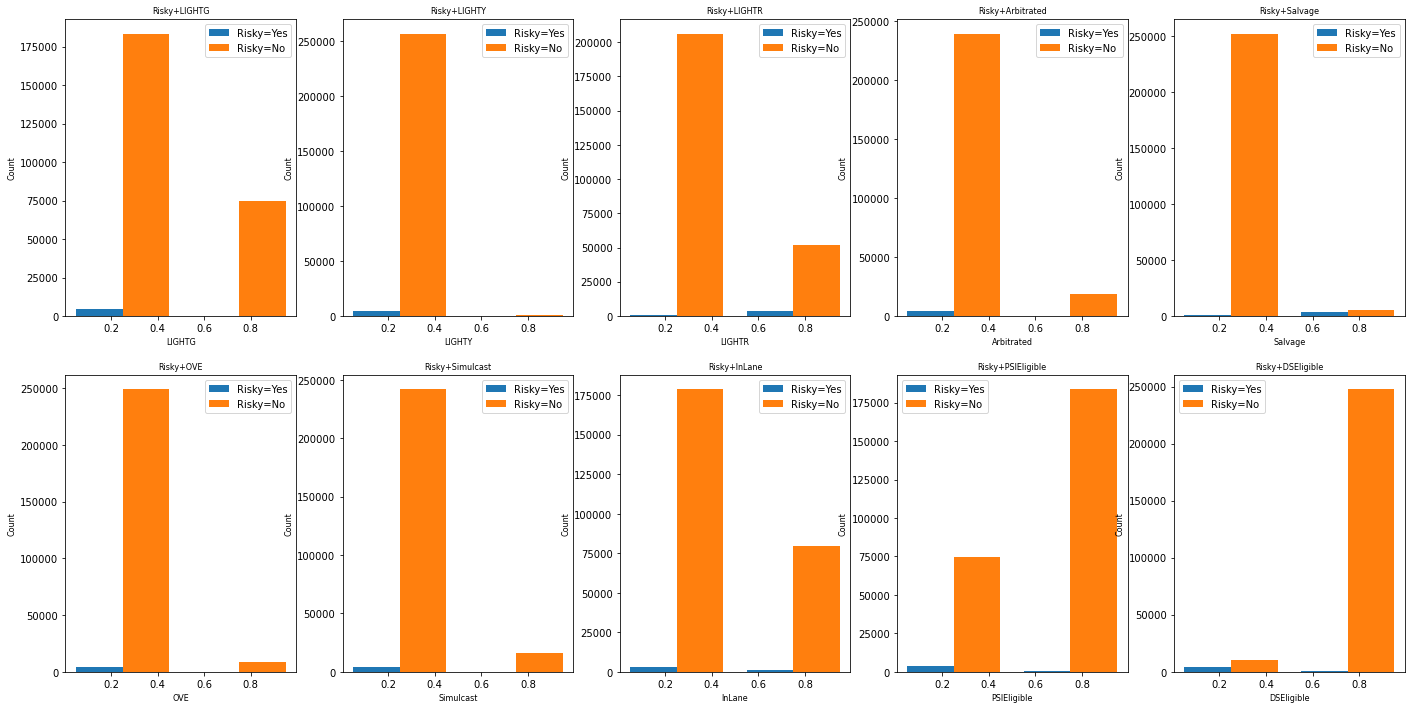

In [54]:
columns = ['LIGHTG', 'LIGHTY', 'LIGHTR', 'Arbitrated', 'Salvage', 'OVE', 'Simulcast', 'InLane','PSIEligible','DSEligible']
index = 0
fig, axs = plt.subplots(2, 5,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = columns[index]
    df = df_risky.dropna(subset=[column])        
    ax.hist([df[df['risky_yes']==1][column],df[df['risky_no']==1][column]],bins=2,label=['Risky=Yes','Risky=No'])
    ax.set_xlabel(column, fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title('Risky+'+column, fontsize=fontsize)
    ax.legend()
    index = index + 1

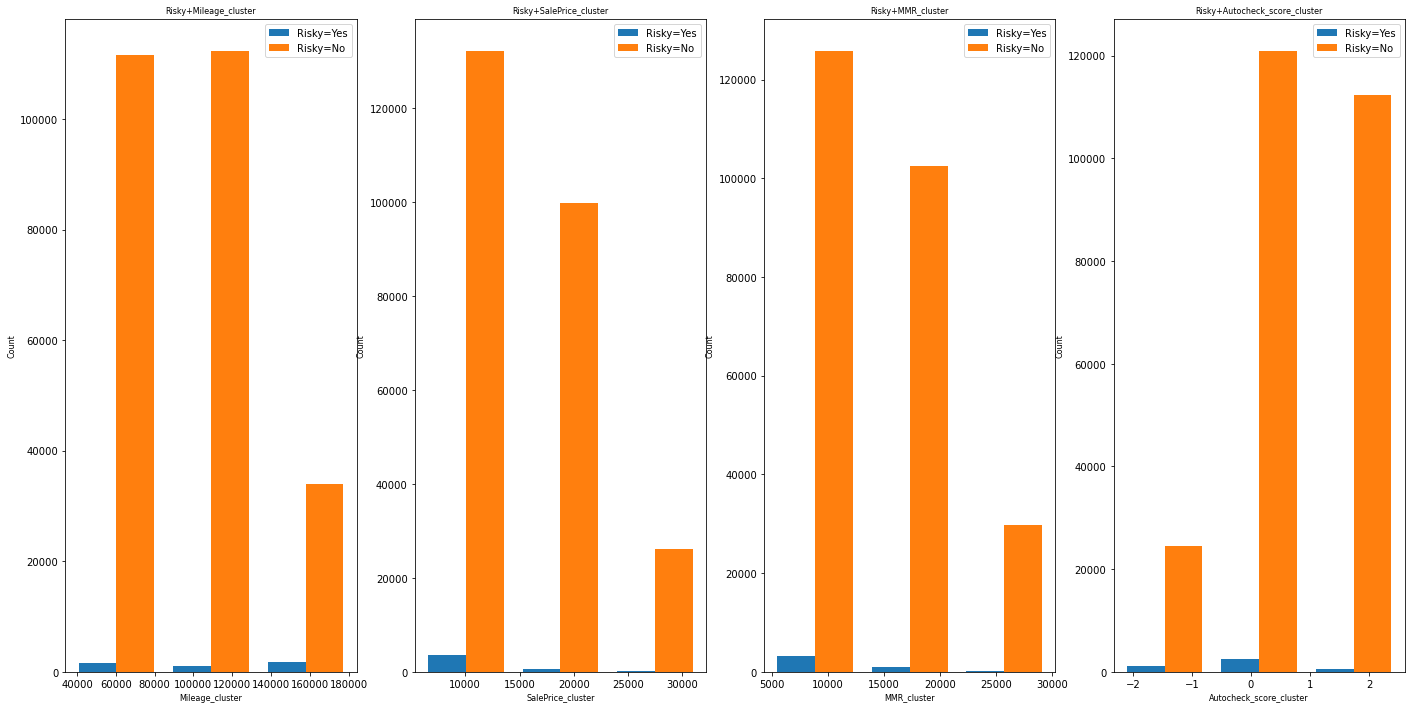

In [55]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans

columns = ['Mileage', 'SalePrice', 'MMR','Autocheck_score']
index = 0
fig, axs = plt.subplots(1,4,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = columns[index]
    df = df_risky.dropna(subset=[column])
    Xt = np.array(df[column],dtype=np.float32).reshape(-1,1)

    kmeans = KMeans(n_clusters=3)
    kmeans.fit(Xt)
    df[column+'_cluster'] = kmeans.predict(Xt)
    centers = kmeans.cluster_centers_
    df[column+'_cluster_center'] = df[column+'_cluster'].apply(lambda s: centers[s][0])
    ax.hist([df[df['risky_yes']==1][column+'_cluster_center'],df[df['risky_no']==1][column+'_cluster_center']],bins=3,label=['Risky=Yes','Risky=No'])
    ax.set_xlabel(column+'_cluster', fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title('Risky+'+column+'_cluster', fontsize=fontsize)
    ax.legend()
    index = index + 1

['Mileage', 'SalePrice'] [[ 98871.74     8544.766 ]
 [ 35806.582   18330.719 ]
 [181526.25     4021.6714]]
['Mileage', 'MMR'] [[ 35625.734   17491.291 ]
 [ 98643.43     8131.6074]
 [181374.25     3721.4575]]
['SalePrice', 'MMR'] [[15413.74  14972.418]
 [ 5773.904  5047.553]
 [30722.143 30097.102]]


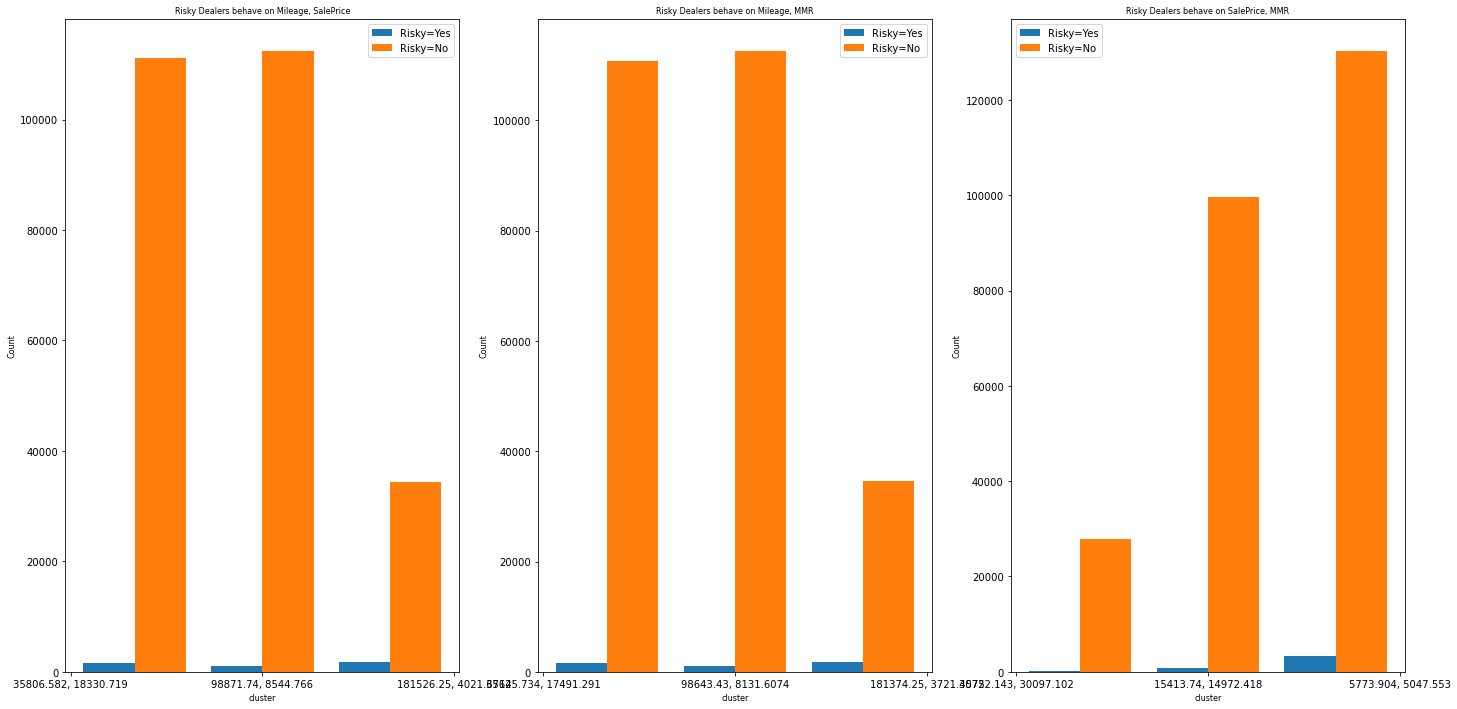

In [56]:
columns = [['Mileage', 'SalePrice'],['Mileage', 'MMR'],[ 'SalePrice', 'MMR']]
index = 0
fig, axs = plt.subplots(1,3,figsize=(24, 12))
fontsize = 8

for ax in axs.flat:
    column = columns[index]
    df = df_risky.dropna(subset=column)
    Xt = np.array(df[column],dtype=np.float32).reshape(-1,len(column))

    kmeans = KMeans(n_clusters=3)
    kmeans.fit(Xt)
    df['cluster'] = kmeans.predict(Xt)
    centers = kmeans.cluster_centers_
    print(column, centers)

    df['cluster_center'] = df['cluster'].apply(lambda s: ', '.join([str(c) for c in centers[s]]))
    ax.hist([df[df['risky_yes']==1]['cluster_center'],df[df['risky_no']==1]['cluster_center']],bins=3,label=['Risky=Yes','Risky=No'])
    ax.set_xlabel('cluster', fontsize=fontsize)
    ax.set_ylabel('Count', fontsize=fontsize)
    ax.set_title('Risky Dealers behave on '+ ', '.join(column), fontsize=fontsize)
    ax.legend()
    index = index + 1